In [1]:
import sklearn
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os

### Loading the stock price dataset

In [2]:
DATA_PATH = 'ford.csv'
if not Path(DATA_PATH).is_file(): 
	ford_stock = yf.download('F',
				start = '2000-01-01',
				end = '2022-08-01',
				progress = False)
	ford_stock.to_csv(DATA_PATH)
else :
	ford_stock = pd.read_csv("ford.csv")

In [3]:
ford_stock.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,28.988474,29.228899,28.645008,28.782394,14.585280,4056814
1,2000-01-04,28.473276,28.713701,27.648958,27.820692,14.097949,7322428
2,2000-01-05,28.026772,28.301542,27.889385,27.923731,14.150164,5038354
3,2000-01-06,28.026772,28.473276,27.683306,27.958078,14.167570,4545037
4,2000-01-07,28.851088,30.224949,28.645008,30.018869,15.211860,9266037


In [4]:
ford_stock[['Close']].shape

(5680, 1)

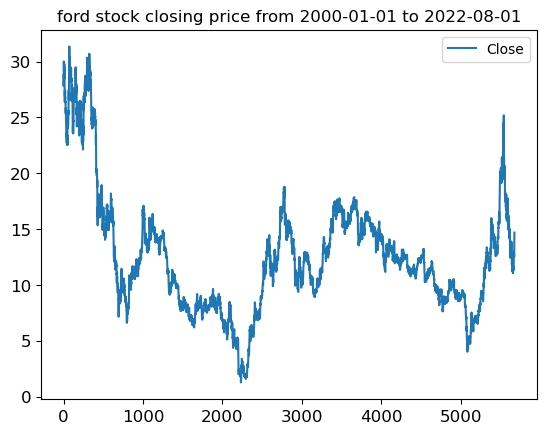

In [5]:
ford_stock[['Close']].plot(title = "ford stock closing price from 2000-01-01 to 2022-08-01")
plt.show()

In [6]:
closing_price = ford_stock[['Close']]

#### Normalizing the dataset

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

closing_price = closing_price.copy()
closing_price.loc[:, ['Close']] = scaler.fit_transform(closing_price[['Close']].values.reshape(-1,1))


#### Splitting the dataset into train, validate and test sets

In [8]:
def convert_to_sequences(data, sequence_length) :
	sequence_length = 20 
	sequence_chunk = sequence_length + 1
	chunks = [data[i : i + sequence_chunk] for i in range(len(data) - sequence_chunk)]

	return chunks

sequence_length = 20
sequenced_data = convert_to_sequences(closing_price['Close'], sequence_length)

In [9]:
def split_dataset(data):
	data = np.array(data)
	test_size = int(0.2 * data.shape[0])
	val_size = int((data.shape[0] - test_size) * 0.2)
	train_size = data.shape[0] - (test_size + val_size)

	x_train = data[:train_size, :-1]
	y_train = data[:train_size, -1]

	x_val = data[train_size : (train_size + val_size), :-1]
	y_val = data[train_size : (train_size + val_size), -1]

	x_test = data[(train_size + val_size):, :-1]
	y_test = data[(train_size + val_size):, -1]


	return [x_train, y_train, x_test, y_test, x_val, y_val]


x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(sequenced_data)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape) 


x_train.shape =  (3623, 20)
y_train.shape =  (3623,)
x_test.shape =  (1131, 20)
y_test.shape =  (1131,)
x_val.shape =  (905, 20)
y_val.shape =  (905,)


In [10]:
def insert_new_axis(x_train, y_train, x_test, y_test, x_val, y_val) :
	if x_train.ndim != 3 and y_train.ndim != 2 :
		x_train = x_train[:,:, np.newaxis]
		y_train = y_train[:, np.newaxis]
		x_test = x_test[:,:, np.newaxis]
		y_test = y_test[:, np.newaxis]
		x_val = x_val[:,:, np.newaxis]
		y_val = y_val[:, np.newaxis]

	if type(x_train) != torch.Tensor :
		x_train = torch.from_numpy(x_train).type(torch.Tensor)
		y_train = torch.from_numpy(y_train).type(torch.Tensor)
		x_test = torch.from_numpy(x_test).type(torch.Tensor)
		y_test = torch.from_numpy(y_test).type(torch.Tensor)
		x_val = torch.from_numpy(x_val).type(torch.Tensor)
		y_val = torch.from_numpy(y_val).type(torch.Tensor)

	return x_train, y_train, x_test, y_test, x_val, y_val


x_train, y_train, x_test, y_test, x_val, y_val = insert_new_axis(x_train, y_train, x_test, y_test, x_val, y_val)

print('x_train.shape = ',x_train.size())
print('y_train.shape = ',y_train.size())
print('x_test.shape = ',x_test.size())
print('y_test.shape = ',y_test.size())
print('x_val.shape = ',x_val.size())
print('y_val.shape = ',y_val.size())

x_train.shape =  torch.Size([3623, 20, 1])
y_train.shape =  torch.Size([3623, 1])
x_test.shape =  torch.Size([1131, 20, 1])
y_test.shape =  torch.Size([1131, 1])
x_val.shape =  torch.Size([905, 20, 1])
y_val.shape =  torch.Size([905, 1])


In [11]:
import psutil

psutil.virtual_memory()

svmem(total=8589934592, available=2497400832, percent=70.9, used=4924952576, free=168304640, active=2330861568, inactive=2283556864, wired=2594091008)

### Defining the RNN/LSTM class

In [12]:
class LSTM(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, num_layers):
    super(LSTM, self).__init__()

    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.output_size = output_size
    self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])
   
    return out

In [13]:
torch.manual_seed(1)
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

model = LSTM(input_size= input_dim, output_size= output_dim, hidden_dim=  hidden_dim, num_layers= 2)


print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
  print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Defining class for prediction and validation

In [14]:
class RNN_stock_predictor :
    def __init__(self, model, loss_fn, optimizer) :
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loss = []
        self.val_loss = []


    def train(self, x_train, y_train, x_val=None, y_val=None) :
        loss_history = []
        output_model = []
        num_epochs = 100

        for i in range(num_epochs):
            output_from_model = self.model(x_train)
            output_model.append(output_from_model)
            loss = self.loss_fn(output_from_model, y_train)
            loss_history.append(loss.item())
            self.train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            self.validate(x_val, y_val)
            if i % 5 == 0 and i!= 0:
                print(f'"Epoch:  {i}, Train MSE Loss: {loss.item() :.5f}   Val MSE loss : {self.val_loss[-1]:.5f}')
        return output_from_model

    def validate(self, x_val, y_val) :
        self.model.eval()
        with torch.no_grad() :
            test_loss = []
            output_model = []
            output_from_model = self.predict(x_val)
            output_model.append(output_from_model)
            loss = self.loss_fn(output_from_model, y_val)
            self.val_loss.append(loss.item())

    def predict(self, seq) :
            y_pred = self.model(seq)

            return y_pred

    def plot_loss(self) :
        plt.plot(np.asarray(self.train_loss), label="Training Loss")
        plt.plot(np.asarray(self.val_loss), label="Validation Loss")
        plt.legend()
        plt.show()

    def predict_future(self, future = None) :
        DAYS_TO_PREDICT = future

        with torch.no_grad():
            test_seq = x_test[-1:] #last sequence
            preds = []
            for _ in range(DAYS_TO_PREDICT):
                y_test_pred = model(test_seq)
                pred = torch.flatten(y_test_pred).item()
                preds.append(pred)
                new_seq = test_seq.numpy().flatten()
                new_seq = np.append(new_seq, [pred])
                new_seq = new_seq[1:]
                test_seq = torch.as_tensor(new_seq).view(1, 20, 1).float()

            return preds



## Experimentation
#### Learning rate experimentation

##### Learning rate of 0.001

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
"Epoch:  5, Train MSE Loss: 0.19565   Val MSE loss : 0.02679
"Epoch:  10, Train MSE Loss: 0.16911   Val MSE loss : 0.01506
"Epoch:  15, Train MSE Loss: 0.15352   Val MSE loss : 0.01529
"Epoch:  20, Train MSE Loss: 0.14655   Val MSE loss : 0.02365
"Epoch:  25, Train MSE Loss: 0.13968   Val MSE loss : 0.02622
"Epoch:  30, Train MSE Loss: 0.12708   Val MSE loss : 0.02024
"Epoch:  35, Train MSE Loss: 0.11039   Val MSE loss : 0.01478
"Epoch:  40, Train MSE Loss: 0.08401   Val MSE loss : 0.01221
"Epoch:  45, Train MSE Loss: 0.04608   Val MSE loss : 0.00789
"Epoch:  50, Train MSE Loss: 0.01935   Val MSE loss : 0.01206
"Epoch:  55, Train MSE Loss: 0.02359   Val MSE loss : 0.02053
"Epoch:  60, Train MSE Loss: 0.00986   Val MSE loss : 0.00565
"Epoch:  65, Train MSE Loss: 0.00556   Val MSE loss : 0.00120
"Epoch:  70, Train MSE Loss: 0.00438   Val MSE loss : 0.00116
"Epoch:  75, 

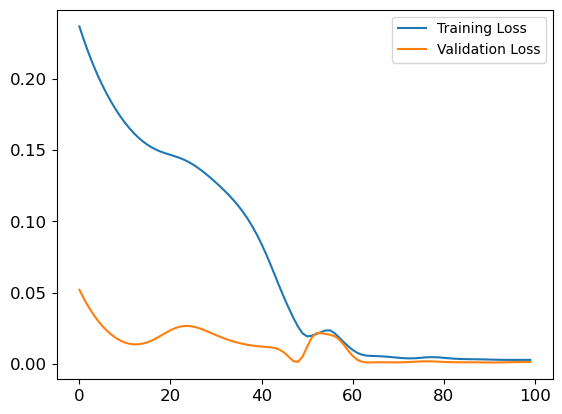

In [15]:
torch.manual_seed(1)
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1 

model = LSTM(input_size= input_dim, output_size= output_dim, hidden_dim=  hidden_dim, num_layers= 2)
print(model)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer =  torch.optim.Adam(model.parameters(), lr= 0.001)
stock_predictor = RNN_stock_predictor(model, loss_fn, optimizer)
model_output = stock_predictor.train(x_train, y_train, x_val, y_val)
stock_predictor.plot_loss()

##### Learning rate of 0.01

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
"Epoch:  5, Train MSE Loss: 0.12878   Val MSE loss : 0.01227
"Epoch:  10, Train MSE Loss: 0.04587   Val MSE loss : 0.04501
"Epoch:  15, Train MSE Loss: 0.00888   Val MSE loss : 0.01422
"Epoch:  20, Train MSE Loss: 0.01242   Val MSE loss : 0.00245
"Epoch:  25, Train MSE Loss: 0.00564   Val MSE loss : 0.00570
"Epoch:  30, Train MSE Loss: 0.00249   Val MSE loss : 0.00420
"Epoch:  35, Train MSE Loss: 0.00340   Val MSE loss : 0.00092
"Epoch:  40, Train MSE Loss: 0.00213   Val MSE loss : 0.00063
"Epoch:  45, Train MSE Loss: 0.00173   Val MSE loss : 0.00054
"Epoch:  50, Train MSE Loss: 0.00150   Val MSE loss : 0.00076
"Epoch:  55, Train MSE Loss: 0.00125   Val MSE loss : 0.00062
"Epoch:  60, Train MSE Loss: 0.00127   Val MSE loss : 0.00045
"Epoch:  65, Train MSE Loss: 0.00113   Val MSE loss : 0.00048
"Epoch:  70, Train MSE Loss: 0.00106   Val MSE loss : 0.00043
"Epoch:  75, 

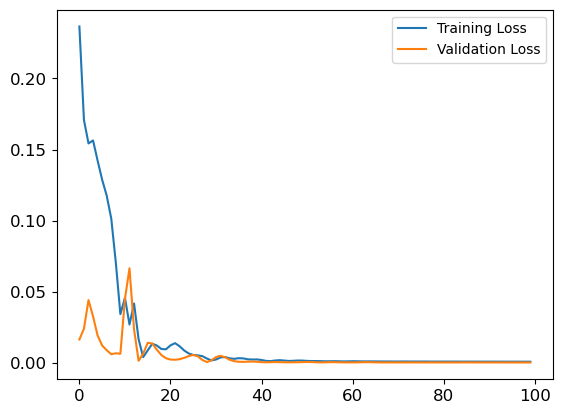

In [18]:
torch.manual_seed(1)
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1 

model = LSTM(input_size= input_dim, output_size= output_dim, hidden_dim=  hidden_dim, num_layers= 2)
print(model)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer =  torch.optim.Adam(model.parameters(), lr= 0.01)
stock_predictor = RNN_stock_predictor(model, loss_fn, optimizer)
model_output = stock_predictor.train(x_train, y_train, x_val, y_val)
stock_predictor.plot_loss()

##### Learning rate of 0.1

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
"Epoch:  5, Train MSE Loss: 0.16282   Val MSE loss : 0.22839
"Epoch:  10, Train MSE Loss: 0.39128   Val MSE loss : 0.13227
"Epoch:  15, Train MSE Loss: 0.16549   Val MSE loss : 0.05695
"Epoch:  20, Train MSE Loss: 0.22687   Val MSE loss : 0.10441
"Epoch:  25, Train MSE Loss: 0.16940   Val MSE loss : 0.02473
"Epoch:  30, Train MSE Loss: 0.17175   Val MSE loss : 0.01920
"Epoch:  35, Train MSE Loss: 0.17166   Val MSE loss : 0.01506
"Epoch:  40, Train MSE Loss: 0.16053   Val MSE loss : 0.02308
"Epoch:  45, Train MSE Loss: 0.16532   Val MSE loss : 0.02910
"Epoch:  50, Train MSE Loss: 0.16000   Val MSE loss : 0.01707
"Epoch:  55, Train MSE Loss: 0.16079   Val MSE loss : 0.01419
"Epoch:  60, Train MSE Loss: 0.15794   Val MSE loss : 0.01564
"Epoch:  65, Train MSE Loss: 0.15076   Val MSE loss : 0.01550
"Epoch:  70, Train MSE Loss: 0.12224   Val MSE loss : 0.00882
"Epoch:  75, 

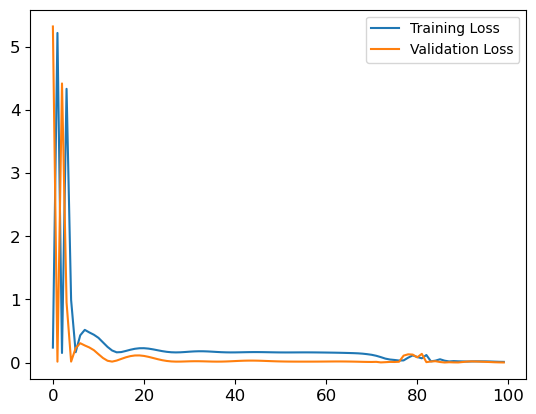

In [16]:
torch.manual_seed(1)
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1 

model = LSTM(input_size= input_dim, output_size= output_dim, hidden_dim=  hidden_dim, num_layers= 2)
print(model)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer =  torch.optim.Adam(model.parameters(), lr= 0.1)
stock_predictor = RNN_stock_predictor(model, loss_fn, optimizer)
model_output = stock_predictor.train(x_train, y_train, x_val, y_val)
stock_predictor.plot_loss()

## PREDICTING ONE DAY INTO THE FUTURE

#### Model training

In [15]:
torch.manual_seed(1)
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1 

model = LSTM(input_size= input_dim, output_size= output_dim, hidden_dim=  hidden_dim, num_layers= 2)
print(model)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer =  torch.optim.Adam(model.parameters(), lr= 0.01)
stock_predictor = RNN_stock_predictor(model, loss_fn, optimizer)
model_output = stock_predictor.train(x_train, y_train, x_val, y_val)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
"Epoch:  5, Train MSE Loss: 0.12878   Val MSE loss : 0.01227
"Epoch:  10, Train MSE Loss: 0.04587   Val MSE loss : 0.04501
"Epoch:  15, Train MSE Loss: 0.00888   Val MSE loss : 0.01422
"Epoch:  20, Train MSE Loss: 0.01242   Val MSE loss : 0.00245
"Epoch:  25, Train MSE Loss: 0.00564   Val MSE loss : 0.00570
"Epoch:  30, Train MSE Loss: 0.00249   Val MSE loss : 0.00420
"Epoch:  35, Train MSE Loss: 0.00340   Val MSE loss : 0.00092
"Epoch:  40, Train MSE Loss: 0.00213   Val MSE loss : 0.00063
"Epoch:  45, Train MSE Loss: 0.00173   Val MSE loss : 0.00054
"Epoch:  50, Train MSE Loss: 0.00150   Val MSE loss : 0.00076
"Epoch:  55, Train MSE Loss: 0.00125   Val MSE loss : 0.00062
"Epoch:  60, Train MSE Loss: 0.00127   Val MSE loss : 0.00045
"Epoch:  65, Train MSE Loss: 0.00113   Val MSE loss : 0.00048
"Epoch:  70, Train MSE Loss: 0.00106   Val MSE loss : 0.00043
"Epoch:  75, 

#### Training and validation loss curves

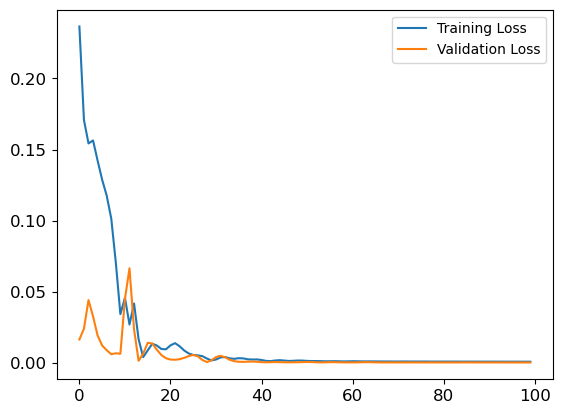

In [16]:
stock_predictor.plot_loss()

#### Training prediction close price vs original close price

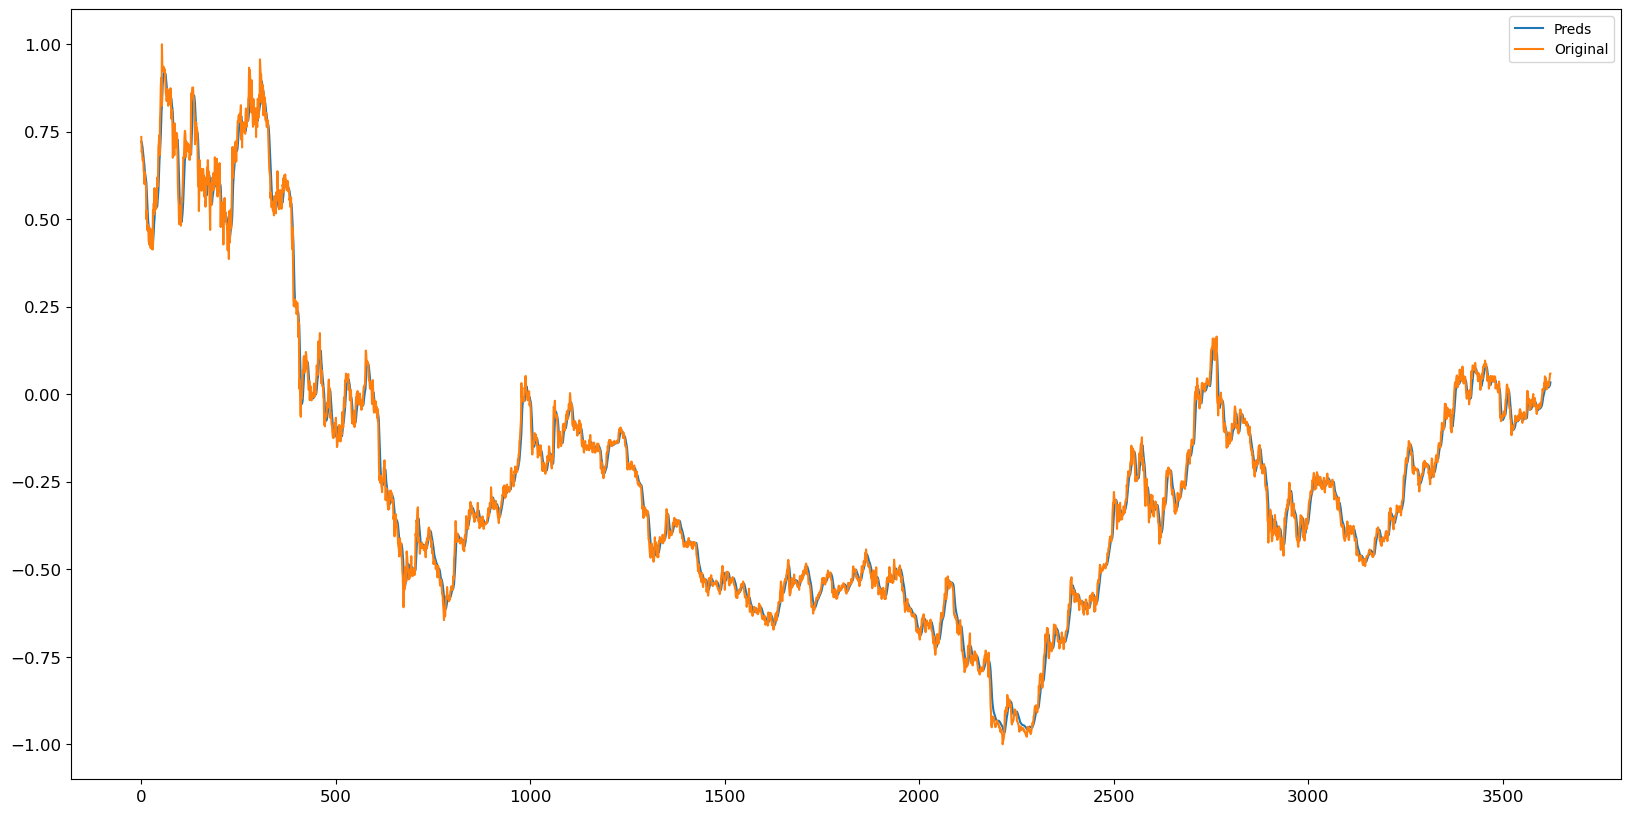

In [17]:
plt.figure(figsize = (20,10))
plt.plot(model_output.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Original")
plt.legend()
plt.show()


### Prediction on the test set

In [18]:
y_test_pred = stock_predictor.predict(x_test)

# converting back to original values
y_train_pred = scaler.inverse_transform(model_output.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

### Test vs train set RMSE value

In [46]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


train_rmse = sqrt(mean_squared_error(y_train[:,], y_train_pred[:,]))
train_mse = mean_squared_error(y_train[:,], y_train_pred[:,])
train_mae = mean_absolute_error(y_train[:,], y_train_pred[:,])
train_mape = mean_absolute_percentage_error(y_train[:,], y_train_pred[:,])
print("Train rmse: ", train_rmse)
print("Train mse: ", train_mse)
print("Train mae: ", train_mae)
print("Train mape: ", train_mape)
test_rmse = sqrt(mean_squared_error(y_test[:,], y_test_pred[:,]))
test_mse = mean_squared_error(y_train[:,], y_train_pred[:,])
test_mae = mean_absolute_error(y_test[:,], y_test_pred[:,])
test_mape = mean_absolute_percentage_error(y_train[:,], y_train_pred[:,])
print("Test rmse: ", test_rmse)
print("test mse: ", test_mse)
print("Test mae: ", test_mae)
print("Test mape: ", test_mape)


Train rmse:  0.46259778252073036
Train mse:  0.21399671
Train mae:  0.32955432
Train mape:  0.032143068
Test rmse:  0.45890370735500535
test mse:  0.21399671
Test mae:  0.3028638
Test mape:  0.032143068


### predictions from test set vs original test set values

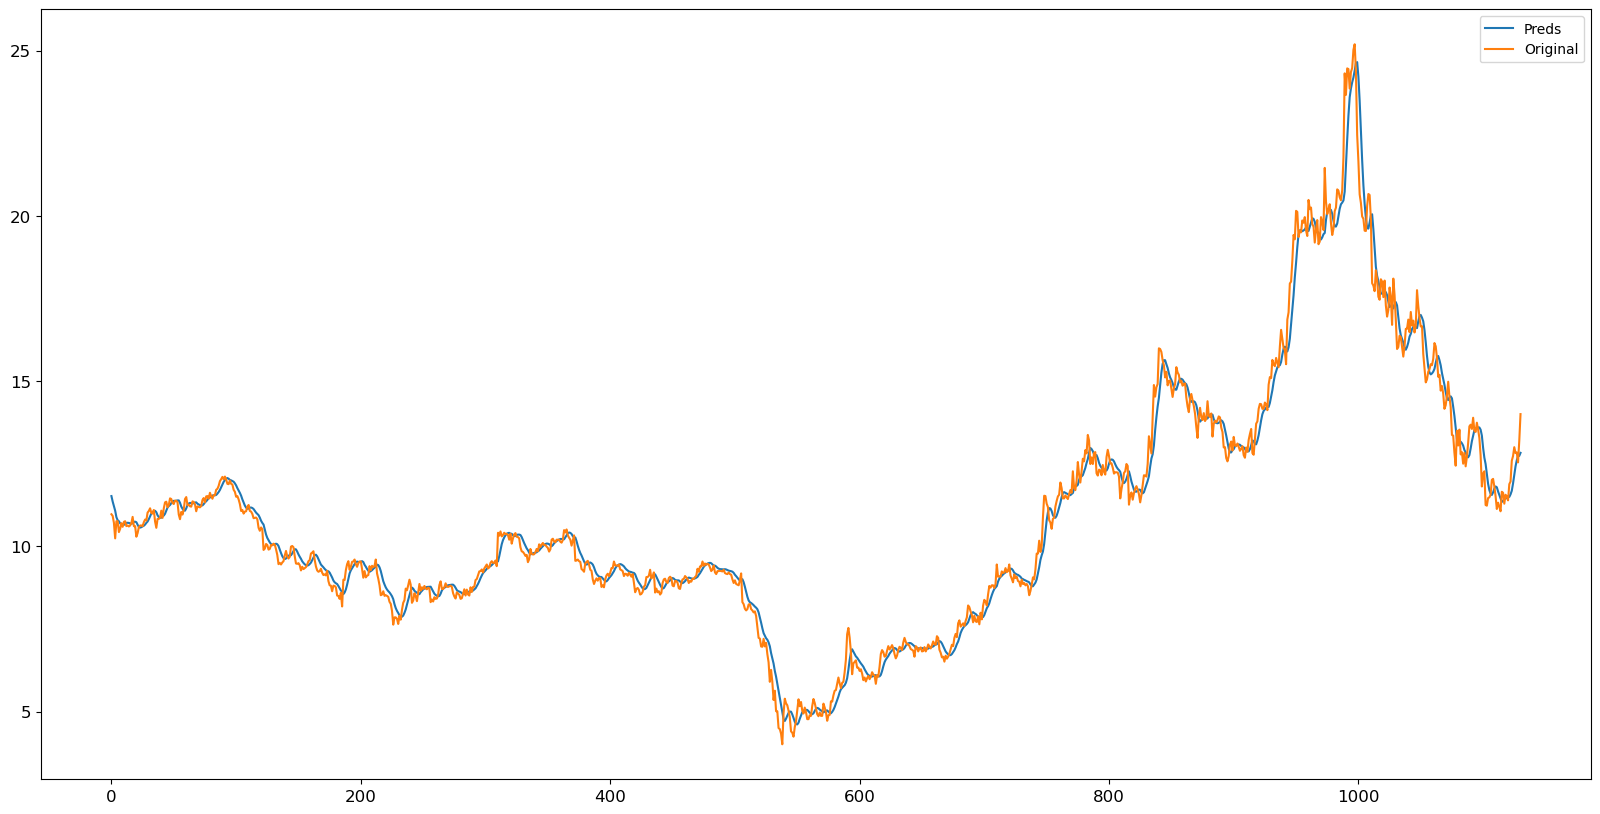

In [20]:
plt.figure(figsize=(20,10))
plt.plot(y_test_pred, label="Preds")
plt.plot(y_test, label="Original")
plt.legend()
plt.show()

### Predicting 5 Days into the future

In [39]:
predicted_cases = stock_predictor.predict_future(future= 5)

predicted_cases = scaler.inverse_transform(
  np.expand_dims(predicted_cases, axis=0)
).flatten()


In [40]:
y_test_trans =y_test[-5:]
y_test_trans


future_mae = mean_absolute_error(predicted_cases, y_test_trans)
print(f'5 day mae :{future_mae}')

future_rmse = sqrt(mean_squared_error(predicted_cases, y_test_trans))
print(f'5 day rmse :{future_rmse}')

future_mape = mean_absolute_percentage_error(predicted_cases, y_test_trans)
print(f'5 day mape :{future_mape}')

5 day mae :0.3564165196169927
5 day rmse :0.5349118663876602
5 day mape :0.027649154184429675


#### Predicting 10 days into the future

In [41]:
predicted_cases = stock_predictor.predict_future(future= 10)

predicted_cases = scaler.inverse_transform(
  np.expand_dims(predicted_cases, axis=0)
).flatten()

In [42]:
y_test_trans =y_test[-10:]
y_test_trans


future_mae = mean_absolute_error(predicted_cases, y_test_trans)
print(f'10 day mae :{future_mae}')

future_rmse = sqrt(mean_squared_error(predicted_cases, y_test_trans))
print(f'10 day rmse :{future_rmse}')

future_mape = mean_absolute_percentage_error(predicted_cases, y_test_trans)
print(f'10 day mape :{future_mape}')

10 day mae :0.4290244519281822
10 day rmse :0.5708219507012906
10 day mape :0.033316045930232366


#### Predicting 15 days into the future

In [43]:
predicted_cases = stock_predictor.predict_future(future= 15)

predicted_cases = scaler.inverse_transform(
  np.expand_dims(predicted_cases, axis=0)
).flatten()


In [44]:
y_test_trans =y_test[-15:]
y_test_trans


future_mae = mean_absolute_error(predicted_cases, y_test_trans)
print(f'15 day mae :{future_mae}')

future_rmse = sqrt(mean_squared_error(predicted_cases, y_test_trans))
print(f'15 day rmse :{future_rmse}')

future_mape = mean_absolute_percentage_error(predicted_cases, y_test_trans)
print(f'15 day mape :{future_mape}')

15 day mae :0.7612868126304552
15 day rmse :0.9421369231469726
15 day mape :0.059077065373141044
